In [5]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip show torch torchvision

Name: torch
Version: 2.5.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: C:\Users\msrib\anaconda3\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, setuptools, sympy, typing-extensions
Required-by: ISLP, pytorch-lightning, torchmetrics, torchvision
---
Name: torchvision
Version: 0.20.1
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: C:\Users\msrib\anaconda3\Lib\site-packages
Requires: numpy, pillow, torch
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset

import matplotlib.pyplot as plt

### Paths

In [2]:
ls data

 Volume in drive C is Windows-SSD
 Volume Serial Number is 8CC9-5F53

 Directory of C:\Users\msrib\Documents\GitHub\Emotion-detection\data

11/05/2024  11:35 AM    <DIR>          .
11/19/2024  05:51 PM    <DIR>          ..
11/05/2024  11:35 AM    <DIR>          FER-2013
11/05/2024  11:35 AM    <DIR>          JAFFE
11/05/2024  11:35 AM    <DIR>          KDEF
               0 File(s)              0 bytes
               5 Dir(s)  396,903,518,208 bytes free


In [56]:
kdef_dir = 'data/KDEF'
fer_train = 'data/FER-2013/train'
fer_test = 'data/FER-2013/test'

### Define transformations

In [57]:
transform = transforms.Compose([
    transforms.CenterCrop((600, 600)),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  
    transforms.ToTensor()           
])

transform2 = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()          
])



### Create dataset using ImageFolder

In [58]:
fer_train = datasets.ImageFolder(root=fer_train, transform=transform2)
fer_test = datasets.ImageFolder(root=fer_test, transform=transform2)

fer_dataset = ConcatDataset([fer_train, fer_test])
kdef_dataset = datasets.ImageFolder(root=kdef_dir, transform=transform)


dataset = ConcatDataset([kdef_dataset, fer_dataset])

In [6]:
fer_dataset[0][0].shape

torch.Size([1, 128, 128])

In [7]:
len(kdef_dataset)

2938

In [8]:
len(dataset)

38825

In [9]:
classes = kdef_dataset.classes
classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [10]:
fer_train.classes

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### Split the data into train, val, test

In [59]:
# define sizes of train, val and test
train_size = int(0.7 * len(dataset))  # 70% for train
val_size = int(0.15 * len(dataset))   # 15% for validation
test_size = len(dataset) - train_size - val_size  # rest for testing

# splitting dataset into train, val, test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoader for each part
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [12]:
print(train_size, test_size, val_size)

27177 5825 5823


In [13]:
def show_img(loader):

    data_iter = iter(train_loader)
    images, labels = next(data_iter)
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,8))

    for i, image in enumerate(images[:5]):
        ax[i].imshow(image[0],cmap='gray')
        ax[i].set_title(classes[labels[i]])
        ax[i].axis('off')
    

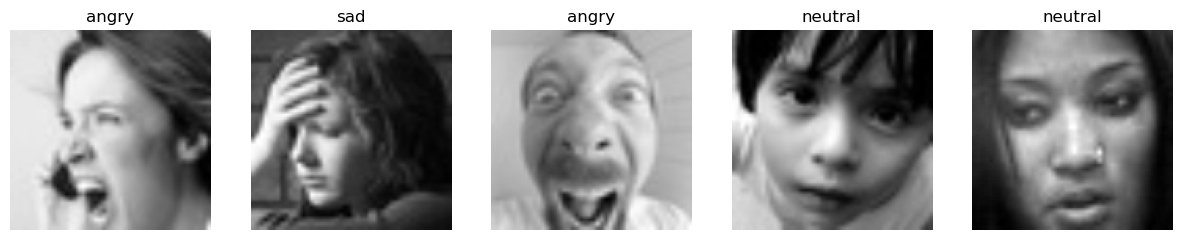

In [14]:
show_img(train_loader)

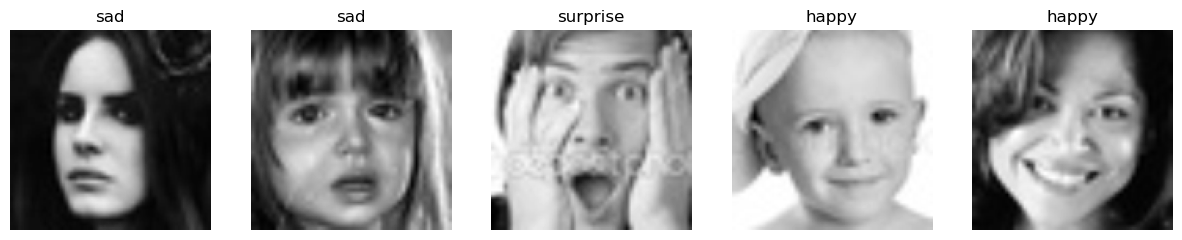

In [15]:
show_img(val_loader)

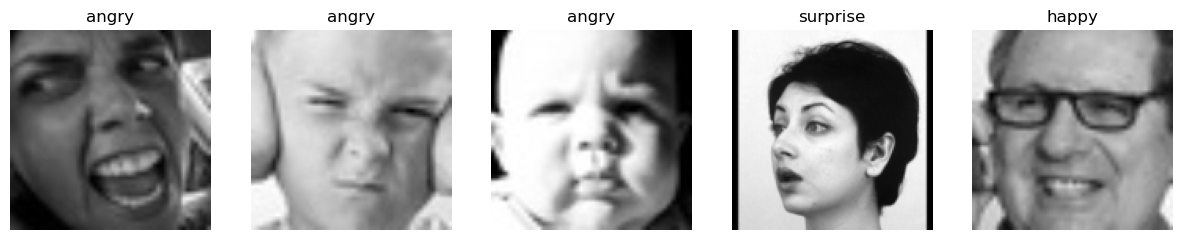

In [16]:
show_img(test_loader)

In [17]:
from collections import Counter


# Get the class indices for each image in the dataset
class_counts = Counter([label for _, label in dataset])

# Get the class names from the dataset
class_names = fer_train.classes

# Print the class balance
for class_idx, count in class_counts.items():
    print(f"Class '{class_names[class_idx]}': {count} images")


Class 'angry': 5373 images
Class 'disgust': 967 images
Class 'fear': 5541 images
Class 'happy': 9409 images
Class 'neutral': 6618 images
Class 'sad': 6496 images
Class 'surprise': 4421 images


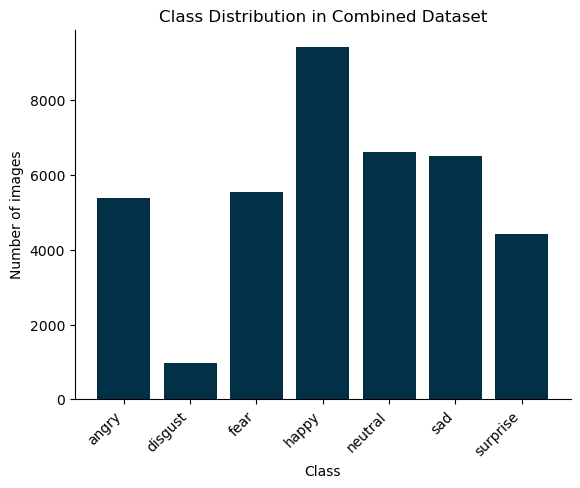

In [60]:
fig, ax = plt.subplots()
ax.bar(class_names, class_counts.values(), color='#023047')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
ax.set_title('Class Distribution in Combined Dataset')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45, ha='right')
ax.spines[['top','right']].set_visible(False)
plt.show()


In [61]:
import torch
import torch.nn as nn

class DeepCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DeepCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x


In [62]:
model = DeepCNN()

In [63]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [67]:
import torch
print(torch.cuda.is_available())


False


In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()


        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")



Epoch 1/10, Loss: 1.8165
Epoch 2/10, Loss: 1.5496
Epoch 3/10, Loss: 1.3360
Epoch 4/10, Loss: 1.1469
Epoch 5/10, Loss: 0.9210
Epoch 6/10, Loss: 0.6811
Epoch 7/10, Loss: 0.4657
Epoch 8/10, Loss: 0.3452
Epoch 9/10, Loss: 0.2753
Epoch 10/10, Loss: 0.2278


In [71]:
# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
print(f'Validation Accuracy: {100 * correct / total:.2f}%')

# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')


Validation Accuracy: 52.84%
Test Accuracy: 53.89%


In [72]:
from torchvision.models import mobilenet_v2

model = mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(1280, num_classes)  # Adjust for your dataset


C:\Users\msrib\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\msrib\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\msrib/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:00<00:00, 31.2MB/s]


In [ ]:
# Validation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
print(f'Validation Accuracy: {100 * correct / total:.2f}%')

# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
print(f'Test Accuracy: {100 * correct / total:.2f}%')
